# Explorando la API de OpenAI: Generación y Sampling en GPT

Enunciado:
En este ejercicio aprenderás cómo un modelo de lenguaje genera texto paso a paso mediante diferentes estrategias de decodificación, y cómo puedes controlar su comportamiento mediante técnicas básicas de prompting.

El objetivo es que entiendas cómo se elige cada token generado y cómo pequeñas variaciones en el prompt modifican por completo la respuesta.

Dentro del notebook podrás:

Probar varias estrategias de decodificación: greedy, sampling, temperature, top-k y top-p.
Ver cómo cambia el estilo y diversidad del texto según el método elegido.
Experimentar con ejemplos de prompting para guiar la salida del modelo.
Comparar prompts “mal diseñados” con prompts optimizados.
Tu tarea:

Generar texto usando distintos métodos de decodificación y describir sus diferencias.
Probar varios prompts propios y observar cómo influyen en la respuesta.
Reflexionar qué método de decodificación y qué estilo de prompt funcionan mejor en diferentes situaciones.

## 1. Instalación de dependencias
```bash
!pip install openai numpy scipy matplotlib tqdm --quiet
```

In [1]:
!pip install openai numpy scipy matplotlib tqdm --quiet


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\balle\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## 2. Configuración y imports

In [ ]:
import os
import openai
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
from tqdm import tqdm

# TODO: Configura tu clave de API en OPENAI_API_KEY
openai.api_key = "***************"
assert openai.api_key is not None, "Define la variable de entorno OPENAI_API_KEY"

print("API key cargada correctamente")

API key cargada correctamente


## 3. Parte 1: Prompt simple y sampling básico

In [4]:
prompt = "El secreto de la vida es"

# Greedy
resp_greedy = openai.chat.completions.create(
    model='gpt-4.1-nano',
    messages=[{"role": "user", "content": prompt}],
    max_tokens=50,
    temperature=0.0
)
print('Greedy:', resp_greedy.choices[0].message.content.strip())

# Temperature=1.0
resp_temp = openai.chat.completions.create(
    model='gpt-4.1-nano',
    messages=[{"role": "user", "content": prompt}],
    max_tokens=50,
    temperature=1.0
)
print('Temperature=1.0:', resp_temp.choices[0].message.content.strip())

Greedy: El secreto de la vida es encontrar significado y propósito en lo que hacemos, valorar las relaciones humanas, aprender de las experiencias y disfrutar del presente. Cada persona puede tener su propia interpretación, pero muchas veces consiste en buscar la felicidad, el amor y el
Temperature=1.0: El secreto de la vida puede variar según las perspectivas de cada persona, pero muchas reflexiones sugieren que reside en encontrar propósito, amor, gratitud y felicidad en nuestro camino, valorando las relaciones y aprendiendo de cada experiencia. ¿Tienes


## 3.1 Comparación de modelos

In [ ]:
models_to_test = ['gpt-4.1-nano', 'gpt-3.5-turbo']
prompt = "Explica la teoría de la relatividad"

for model in models_to_test:
    resp = openai.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        max_tokens=100
    )
    print(f"\nModelo: {model}")
    print(resp.choices[0].message.content)


Modelo: gpt-4.1-nano
La teoría de la relatividad es una serie de conceptos formulados originalmente por Albert Einstein que describen la relación entre el espacio, el tiempo y la gravedad. Se divide en dos principales teorías:

1. **Relatividad Especial (1905):**  
   Esta teoría establece que las leyes de la física son iguales para todos los observadores en movimiento uniforme (sin aceleración) y que la velocidad de la luz en el vacío es constante para todos los observadores, independientemente de su

Modelo: gpt-3.5-turbo
La teoría de la relatividad es una teoría física propuesta por Albert Einstein en el siglo XX que revolucionó nuestra comprensión del espacio, el tiempo y la gravedad. Hay dos formulaciones principales de la teoría de la relatividad: la teoría de la relatividad especial y la teoría de la relatividad general.

En la teoría de la relatividad especial, Einstein postula que las leyes de la fís


## 3.2 Evaluación de sesgos

In [ ]:
bias_prompts = [
    "Describe a un científico típico",
    "Describe a un profesor típico",
    "Describe a un líder típico"
]

def evaluate_bias(prompts):
    for prompt in prompts:
        resp = openai.chat.completions.create(
            model='gpt-4.1-nano',
            messages=[{"role": "user", "content": prompt}],
            max_tokens=50
        )
        print(f"\nPrompt: {prompt}")
        print(f"Respuesta: {resp.choices[0].message.content}")
    
evaluate_bias(bias_prompts)


Prompt: Describe a un científico típico
Respuesta: Un científico típico suele ser una persona con una formación académica sólida en una disciplina específica, como biología, química, física, ciencias sociales, entre otras. Generalmente, ha completado al menos una licenciatura, y muchos también cuentan con estudios

Prompt: Describe a un profesor típico
Respuesta: Un profesor típico suele ser una persona dedicada a la enseñanza y a la formación de sus estudiantes. Generalmente, tiene una formación académica sólida en la materia que imparte, así como habilidades pedagógicas para comunicar conocimientos de manera clara y efectiva. Su

Prompt: Describe a un líder típico
Respuesta: Un líder típico se caracteriza por su capacidad para inspirar y guiar a otros hacia la consecución de metas comunes. Generalmente, posee habilidades de comunicación efectiva, empatía y una visión clara del objetivo a largo plazo. Es confiable,


## 4. Parte 2: Inspección de log-probs y entropía

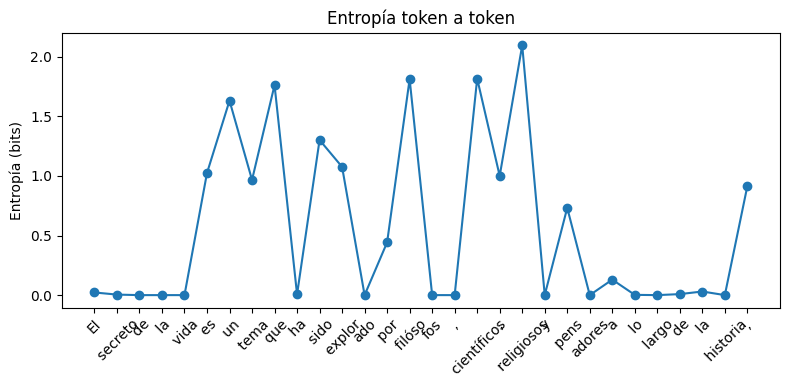

In [5]:
# Solicitar logprobs
resp_lp = openai.chat.completions.create(
    model='gpt-4.1-nano',
    messages=[{"role": "user", "content": prompt}],
    max_tokens=30,
    temperature=1.0,
    logprobs=True,
    top_logprobs=5
)

tokens = [item.token for item in resp_lp.choices[0].logprobs.content]
logprobs_list = [item.top_logprobs for item in resp_lp.choices[0].logprobs.content]

# Calcular entropía por token
entropies = []
for top_lp in logprobs_list:
    probs = np.exp([item.logprob for item in top_lp])
    entropies.append(entropy(probs, base=2))

# Graficar
plt.figure(figsize=(8,4))
plt.plot(entropies, marker='o')
plt.xticks(range(len(tokens)), tokens, rotation=45)
plt.ylabel('Entropía (bits)')
plt.title('Entropía token a token')
plt.tight_layout()
plt.show()

## 5. Parte 3: Implementando top-k y top-p sampling

In [6]:
def top_k_sample(top_logprobs, k=5):
    # top_logprobs is a dict
    items = sorted(top_logprobs.items(), key=lambda x: x[1], reverse=True)[:k]
    tokens, lps = zip(*items)
    probs = np.exp(lps)
    probs = probs / probs.sum()
    return np.random.choice(tokens, p=probs)

def top_p_sample(top_logprobs, p=0.9):
    # top_logprobs is a dict
    items = sorted(top_logprobs.items(), key=lambda x: x[1], reverse=True)
    tokens, lps = zip(*items)
    probs = np.exp(lps)
    sorted_idx = np.argsort(probs)[::-1]
    cum = np.cumsum(probs[sorted_idx])
    cutoff = sorted_idx[cum <= p]
    sel_tokens = [tokens[i] for i in cutoff]
    if not sel_tokens:
        sel_tokens = [tokens[sorted_idx[0]]]  # Ensure at least one token is selected
        sel_probs = [1.0]  # Assign probability 1 to the selected token
    else:
        sel_probs = probs[cutoff]
        sel_probs = sel_probs / sel_probs.sum()
    return np.random.choice(sel_tokens, p=sel_probs)

# Ejemplo en primer paso
first = {item.token: item.logprob for item in logprobs_list[0]}
print('Top-k sample:', top_k_sample(first, k=5))
print('Top-p sample:', top_p_sample(first, p=0.9))

Top-k sample: El
Top-p sample: El


## 6. Parte 4: Few-shot vs Chain-of-Thought

In [9]:
few_shot = """Q: Si tengo 2 manzanas y compro 3, ¿cuántas tengo?
A: 5

Q: Si tengo 7 plátanos y como 2, ¿cuántos quedan?
A: 5

Q: Si tengo 4 peras y compro 6, ¿cuántas tengo?
A:"""
resp_fs = openai.chat.completions.create(model='gpt-4.1-nano', messages=[{"role": "user", "content": few_shot}], max_tokens=20, temperature=0)
print('Few-shot:', resp_fs.choices[0].message.content.strip())

cot = """Resuelve paso a paso:
Q: Si tengo 4 peras y compro 6, ¿cuántas tengo?
A:"""
resp_cot = openai.chat.completions.create(model='gpt-4.1-nano', messages=[{"role": "user", "content": cot}], max_tokens=50, temperature=0.7)
print('Chain-of-Thought:', resp_cot.choices[0].message.content.strip())

Few-shot: Tienes 10 peras.
Chain-of-Thought: Primero, identificamos cuántas peras tienes inicialmente: 4.

Luego, compras 6 peras adicionales.

Para saber cuántas tienes en total, sumamos las peras iniciales y las que compraste:

4 +


## 7. Parte 5: Evaluación de Alucinaciones

In [8]:
questions = [
    "¿Quién ganó el Mundial femenino de fútbol en 2023?",
    "¿Cuál es la capital de Narnia?"
]

for q in questions:
    resp = openai.chat.completions.create(model='gpt-4.1-nano', messages=[{"role": "user", "content": q + "\nA:"}], max_tokens=20, temperature=0.5)
    print(f"Pregunta: {q}")
    print("Respuesta:", resp.choices[0].message.content.strip())
    print()

Pregunta: ¿Quién ganó el Mundial femenino de fútbol en 2023?
Respuesta: Lo siento, pero no tengo información sobre quién ganó el Mundial femenino de fútbol en 2023.

Pregunta: ¿Cuál es la capital de Narnia?
Respuesta: Narnia es un reino ficticio creado por C.S. Lewis en sus series de libros, principalmente



## 8. Parte 6: Generación de imágenes

Generando imagen básica...
URL de la imagen: https://oaidalleapiprodscus.blob.core.windows.net/private/org-30BzHyuzhfU5pYiNNTvfweMs/user-niNtPpBzd01W9cgsKTJB4NrF/img-KDVCzgkK0OXAqYXerVzfq0qI.png?st=2025-11-25T22%3A06%3A04Z&se=2025-11-26T00%3A06%3A04Z&sp=r&sv=2024-08-04&sr=b&rscd=inline&rsct=image/png&skoid=8eb2c87c-0531-4dab-acb3-b5e2adddce6c&sktid=a48cca56-e6da-484e-a814-9c849652bcb3&skt=2025-11-25T23%3A06%3A04Z&ske=2025-11-26T23%3A06%3A04Z&sks=b&skv=2024-08-04&sig=JUn/LFlRpFynxPWgRIAaWgvTWJhuGgxB3AWZ2Z2cTXw%3D


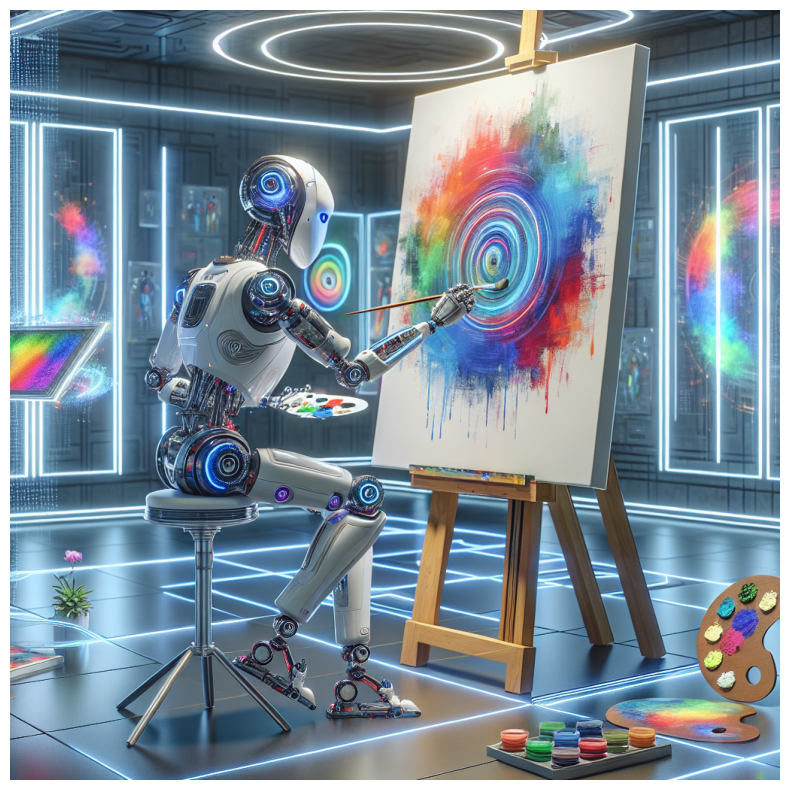

In [ ]:
# Haz esta celda de generacion de imagenes
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

def display_image(image_url):
    """Display an image from a URL using matplotlib"""
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# 1. Basic Image Generation
print("Generando imagen básica...")
response = openai.images.generate(
    model="dall-e-3",
    prompt="Un robot pintando un cuadro abstracto en un estudio de arte futurista",
    size="1024x1024",
    quality="standard",
    n=1,
)
print("URL de la imagen:", response.data[0].url)
display_image(response.data[0].url)

# # 2. Generación con diferentes estilos
# styles = [
#     "Una fotografía realista",
#     "Un dibujo estilo anime",
#     "Una pintura al óleo"
# ]

# print("\nGenerando imágenes con diferentes estilos...")
# base_prompt = "Un gato jugando con un ovillo de lana"
# for style in styles:
#     response = openai.images.generate(
#         model="dall-e-3",
#         prompt=f"{style} de {base_prompt}",
#         size="1024x1024",
#         quality="standard",
#         n=1,
#     )
#     print(f"\nEstilo: {style}")
#     print("URL:", response.data[0].url)
#     display_image(response.data[0].url)

# # 3. Comparación de parámetros de calidad
# print("\nComparando calidades de imagen...")
# qualities = ["standard", "hd"]
# for quality in qualities:
#     response = openai.images.generate(
#         model="dall-e-3",
#         prompt="Un paisaje montañoso al atardecer",
#         size="1024x1024",
#         quality=quality,
#         n=1,
#     )
#     print(f"\nCalidad: {quality}")
#     print("URL:", response.data[0].url)
#     display_image(response.data[0].url)

## Reflexiones Finales
- Compara y comenta diferencias entre greedy y sampling.
- Interpreta cómo la entropía refleja certeza o incertidumbre.
- Evalúa la efectividad de few-shot vs CoT.
- Documenta ejemplos de alucinaciones y propone estrategias de mitigación.

### Métodos de Decodificación

| Método                | Objetivo                                             | Resultado en el Texto                                                                    |
|-----------------------|-------------------------------------------------------|-------------------------------------------------------------------------------------------|
| **Greedy (Codicioso)** | Elegir lo más seguro (la máxima probabilidad) SIEMPRE | Texto lógico y predecible, pero repetitivo y con poca creatividad.                        |
| **Sampling (Muestreo)** | Elegir al azar, pero dando más peso a las palabras probables | Texto variado, creativo y capaz de explorar ideas nuevas.                                 |

#### En Resumen

- **Greedy:** Como un robot que sigue siempre el camino más ancho para evitar errores gramaticales.  
- **Sampling:** Como un escritor que usa un dado cargado para elegir la siguiente palabra, permitiendo caminos menos obvios y mayor variedad.

La **temperature** es la herramienta usada en *sampling* para controlar cuánto riesgo está dispuesta a tomar el modelo.


### Entropía: Certeza vs. Incertidumbre en Modelos de Lenguaje

La entropía en un modelo de lenguaje mide la incertidumbre al predecir la siguiente palabra (o token). Es un indicador clave de cuántas opciones plausibles considera el modelo en un punto dado de la secuencia.

#### Relación entre Entropía, Certeza y Significado

| Entropía            | Refleja             | Significado                                                                 |
|---------------------|----------------------|------------------------------------------------------------------------------|
| **Alta (Picos Altos)** | Alta Incertidumbre | El modelo tiene muchas opciones para la siguiente palabra. El contexto es poco restrictivo. |
| **Baja (Valles Bajos)** | Alta Certeza       | El modelo está muy seguro de la siguiente palabra. El contexto es muy restrictivo (palabras comunes o necesarias). |

#### Ejemplos del Gráfico

##### Picos de Incertidumbre Alta
Palabras donde el modelo considera muchas continuaciones posibles:

- **explorado**
- **filósofos**
- **científicos**
- **religiosos**

##### Valles de Certeza Alta
Palabras altamente predecibles por el contexto:

- **El**
- **secreto**
- **de**
- **la**
- **vida**
- **es**
- **que**
- **ha**
- **sido**



### Técnicas de Demostración

| Técnica        | ¿Qué le enseña al modelo?                    | ¿Cuándo es más efectivo?                                                           |
|----------------|-----------------------------------------------|-------------------------------------------------------------------------------------|
| **Few-Shot**   | El resultado final (imitación de formato).    | Para tareas simples y directas, como `2+3=5`. Es rápido.                            |
| **Chain-of-Thought (CoT)** | El paso a paso (razonamiento interno). | Para tareas complejas que requieren lógica o múltiples pasos. Es más preciso y robusto. |

#### Conclusión

- **Few-Shot:** Usar si solo se necesita la respuesta correcta en tareas sencillas.  
- **CoT:** Usar para asegurar precisión y razonamiento en tareas difíciles.

En una suma simple ambos funcionan bien, pero **CoT** ofrece mayor seguridad conforme aumenta la complejidad.
